In [205]:
from pathlib import Path
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

# Localisation du fichier CSV
current_dir = Path().resolve()
project_root = current_dir.parent
data_path = project_root / "Data" / "Dataset of weighing station temperature measurements.csv"

print("Fichier CSV :", data_path)

df = pd.read_csv(data_path, sep=";")

# Aperçu
# display(df.head())
# print(df.columns)
# Colonnes de température à l'intérieur du puits
low_cols = [c for c in df.columns if "Low" in c]
mid_cols = [c for c in df.columns if "Mid" in c]
top_cols = [c for c in df.columns if "Top" in c]

# trie par numéro de capteur S1, S2, ... 
def trier_par_capteur(liste_colonnes):
    return sorted(liste_colonnes, key=lambda x: int(x.split("-S")[1]))

low_cols = trier_par_capteur(low_cols)
mid_cols = trier_par_capteur(mid_cols)
top_cols = trier_par_capteur(top_cols)

#print("Colonnes Low :", df[top_cols])

df["Time"] = pd.to_datetime(df["Time"])
df = df.set_index("Time").sort_index()


Fichier CSV : C:\Users\slaro\Desktop\Analyse_donnees_TP_TT\Data\Dataset of weighing station temperature measurements.csv


In [ ]:

# Dictionnaire pour les thermocouples de contrôle S1 et S29 

controles_dict = {
    "S1": [1],    # sonde 1
    "S29": [29],  # sonde 29
}

controles_temp = {}

for ctrl_name, sondes in controles_dict.items():
    T_low = df[[low_cols[s-1] for s in sondes]].mean(axis=1)
    T_mid = df[[mid_cols[s-1] for s in sondes]].mean(axis=1)
    T_top = df[[top_cols[s-1] for s in sondes]].mean(axis=1)

    controles_temp[ctrl_name] = {
        "LOW": T_low,
        "MID": T_mid,
        "TOP": T_top,
    }
# print(top_cols, mid_cols, low_cols)
print(T_low)
#Température moyenne verticale pour chaque thermocouple de contrôle 

T_ctrl_S1 = pd.concat(
    [controles_temp["S1"]["LOW"],
     controles_temp["S1"]["MID"],
     controles_temp["S1"]["TOP"]],
    axis=1
).mean(axis=1)

T_ctrl_S29 = pd.concat(
    [controles_temp["S29"]["LOW"],
     controles_temp["S29"]["MID"],
     controles_temp["S29"]["TOP"]],
    axis=1
).mean(axis=1)
#print(T_ctrl_S1)
T_ctrl_S1.name = "T_ctrl_S1"
T_ctrl_S29.name = "T_ctrl_S29"

# Température de contrôle globale (moyenne de S1 et S29)

T_ctrl_globale = pd.concat([T_ctrl_S1, T_ctrl_S29], axis=1).mean(axis=1)
T_ctrl_globale.name = "T_ctrl_globale"

# DataFrame de travail pour l'analyse de la règle de contrôle

df_ctrl = pd.DataFrame(
    {
        "T_ctrl_S1": T_ctrl_S1,
        "T_ctrl_S29": T_ctrl_S29,
        "T_ctrl_globale": T_ctrl_globale,
        "T_ext" : df["Outdoor temperature [deg. C]"]
    },
    index=df.index,  
)

df_ctrl.head()

Time
2023-12-21 12:10:00   -0.396221
2023-12-21 12:12:00   -0.529751
2023-12-21 12:14:00   -0.178601
2023-12-21 12:16:00    1.174747
2023-12-21 12:18:00    0.901145
                         ...   
2024-03-05 13:36:00         NaN
2024-03-05 13:38:00         NaN
2024-03-05 13:40:00         NaN
2024-03-05 13:42:00         NaN
2024-03-05 13:44:00         NaN
Length: 54048, dtype: float64
Time
2023-12-21 12:10:00    35.058788
2023-12-21 12:12:00    35.288603
2023-12-21 12:14:00    34.548132
2023-12-21 12:16:00    34.931228
2023-12-21 12:18:00    35.661821
                         ...    
2024-03-05 13:36:00    16.780171
2024-03-05 13:38:00    16.790831
2024-03-05 13:40:00    16.785502
2024-03-05 13:42:00    16.774843
2024-03-05 13:44:00    16.678905
Length: 54048, dtype: float64


,T_ctrl_S1,T_ctrl_S29,T_ctrl_globale,T_ext
Time,,,,
2023-12-21 12:10:00,35.058788,0.025899,17.542344,-3.883333
2023-12-21 12:12:00,35.288603,-0.078648,17.604977,-3.880000
2023-12-21 12:14:00,34.548132,0.194542,17.371337,-3.876667
2023-12-21 12:16:00,34.931228,1.462444,18.196836,-3.873333
2023-12-21 12:18:00,35.661821,1.253151,18.457486,-3.870000


In [207]:
T = df_ctrl["T_ctrl_globale"].resample("6min").mean()
print(T.head())
df_ctrl_smooth = pd.DataFrame({"T_ctrl_globale": T})

# Variation de température sur 6 minutes
df_ctrl_smooth["dT_6min"] = df_ctrl_smooth["T_ctrl_globale"].diff()

# Seuils pour dire ON / OFF
DT_ON  = 5.0   # °C / 6 min  -> si dT > x°C en 6 min, on considère que ça chauffe
DT_OFF = -5.0  # °C / 6 min -> si dT < -x°C en 6 min, on considère que ça refroidit

etat = pd.Series(index=df_ctrl_smooth.index, dtype="float64")

etat[df_ctrl_smooth["dT_6min"] > DT_ON]  = 1  # ON
etat[df_ctrl_smooth["dT_6min"] < DT_OFF] = 0  # OFF

#Propager l'état (ON jusqu'à OFF suivant, etc.)
etat = etat.ffill().bfill().astype(int)

df_ctrl_smooth["etat_aero"] = etat

#T_ext resamplé 6 min
T_ext_s = df_ctrl["T_ext"].resample("6min").mean().interpolate()
df_ctrl_smooth["T_ext"] = T_ext_s


Time
2023-12-21 12:06:00    17.542344
2023-12-21 12:12:00    17.724383
2023-12-21 12:18:00    18.111664
2023-12-21 12:24:00    18.831439
2023-12-21 12:30:00    18.174314
Freq: 6min, Name: T_ctrl_globale, dtype: float64


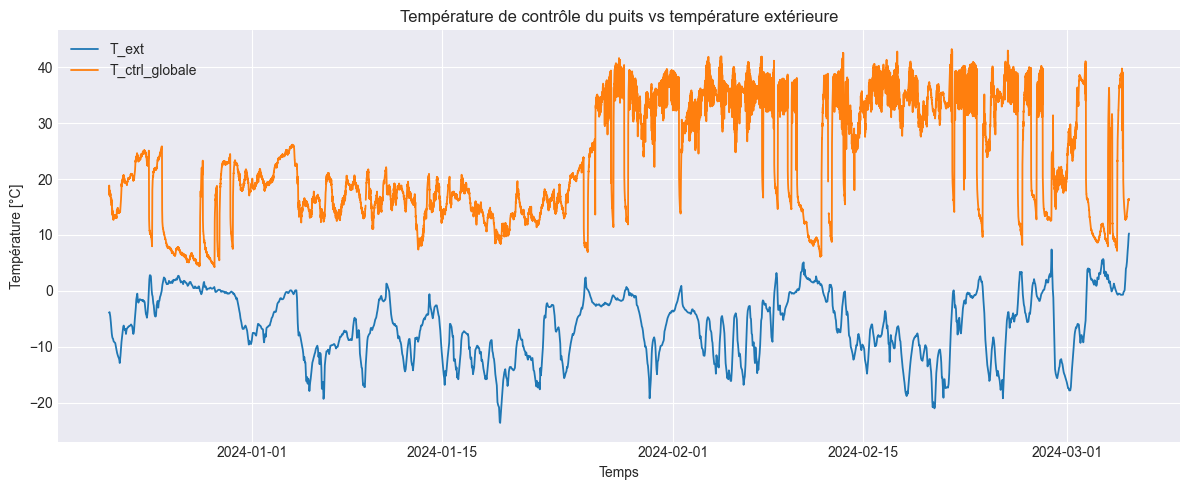

In [208]:
#Graphe T_ctrl et T_ext

plt.figure(figsize=(12,5))

plt.plot(df_ctrl.index, df_ctrl["T_ext"], 
         label="T_ext", linewidth=1.3)

plt.plot(df_ctrl_smooth.index, df_ctrl_smooth["T_ctrl_globale"],
         label="T_ctrl_globale", linewidth=1.3)

plt.xlabel("Temps")
plt.ylabel("Température [°C]")
plt.title("Température de contrôle du puits vs température extérieure")
plt.legend()
plt.tight_layout()
plt.show()

In [209]:
#Instants de transitions OFF/ON et ON/OFF

etat = df_ctrl_smooth["etat_aero"]

transi = etat.diff()

event_on  = transi[transi ==  1].index   # OFF/ON
event_off = transi[transi == -1].index   # ON/OFF

print("Nombre de transitions OFF/ON :", len(event_on))
print("Nombre de transitions ON/OFF :", len(event_off))

Nombre de transitions OFF/ON : 373
Nombre de transitions ON/OFF : 373


In [210]:
#Températures au moment des transitions

T_ctrl_on  = df_ctrl_smooth.loc[event_on,  "T_ctrl_globale"]
T_ctrl_off = df_ctrl_smooth.loc[event_off, "T_ctrl_globale"]

T_ext_on   = df_ctrl_smooth.loc[event_on,  "T_ext"]
T_ext_off  = df_ctrl_smooth.loc[event_off, "T_ext"]
print("OFF/ON")
print("T_ctrl_globale médiane :", T_ctrl_on.median())
print("T_ctrl_globale (min, max) :", T_ctrl_on.min(), T_ctrl_on.max())

print("\n ON/OFF ")
print("T_ctrl_globale médiane :", T_ctrl_off.median())
print("T_ctrl_globale (min, max) :", T_ctrl_off.min(), T_ctrl_off.max())

print("\nT_ext")
print("OFF/ON : T_ext médiane :", T_ext_on.median(), "  (min, max) :",
      T_ext_on.min(), T_ext_on.max())
print("ON/OFF : T_ext médiane :", T_ext_off.median(), " (min, max) :",
      T_ext_off.min(), T_ext_off.max())
print('\nT_ext min max :', T_ext.min(), ';', T_ext.max())

OFF/ON
T_ctrl_globale médiane : 38.4595965225
T_ctrl_globale (min, max) : 13.146165205444445 43.2254580575

 ON/OFF 
T_ctrl_globale médiane : 32.34974739777778
T_ctrl_globale (min, max) : 14.288246015833332 36.6581040525

T_ext
OFF/ON : T_ext médiane : -3.533333333333333   (min, max) : -14.020000000000001 7.146666666666666
ON/OFF : T_ext médiane : -3.526666666666667  (min, max) : -13.75 1.47

T_ext min max : -23.6 ; 10.26666667


In [211]:
import datetime as dt
date_split = dt.datetime(2024, 1, 26)

event_on_avant  = event_on[event_on  < date_split]
event_on_apres  = event_on[event_on  >= date_split]
event_off_avant = event_off[event_off < date_split]
event_off_apres = event_off[event_off >= date_split]

def stats_transi(evenements, label):
    T_ctrl_vals = df_ctrl_lisse.loc[evenements, "T_ctrl_globale"]
    print(f"{label}")
    print("  n =", len(evenements))
    print("  T_ctrl_globale médiane :", T_ctrl_vals.median())
    print("  T_ctrl_globale (min, max) :", T_ctrl_vals.min(), T_ctrl_vals.max())
    print()

stats_transi(event_on_avant,  "OFF/ON AVANT 26 janv")
stats_transi(event_on_apres,  "OFF/ON APRÈS 26 janv")
stats_transi(event_off_avant, "ON/OFF AVANT 26 janv")
stats_transi(event_off_apres, "ON/OFF APRÈS 26 janv")

OFF/ON AVANT 26 janv
  n = 2
  T_ctrl_globale médiane : 13.81863894038889
  T_ctrl_globale (min, max) : 13.146165205444445 14.491112675333333

OFF/ON APRÈS 26 janv
  n = 371
  T_ctrl_globale médiane : 38.46340451166667
  T_ctrl_globale (min, max) : 15.715756595333332 43.2254580575

ON/OFF AVANT 26 janv
  n = 1
  T_ctrl_globale médiane : 14.288246015833332
  T_ctrl_globale (min, max) : 14.288246015833332 14.288246015833332

ON/OFF APRÈS 26 janv
  n = 372
  T_ctrl_globale médiane : 32.360516448472225
  T_ctrl_globale (min, max) : 16.328376995166668 36.6581040525



 Après le 26 janvier, les cycles sont nombreux (≈ 370) et se produisent presque uniquement lorsque la température extérieure est inférieure à quelques degrés au-dessus de 0 °C, ce qui est cohérent avec l’idée que le système ne chauffe que par temps froid. En se basant sur la température moyenne de contrôle du puits, on observe des enclenchements typiques autour de 32–33 °C et des coupures autour de 38–39 °C, soit une bande d’hystérésis d’environ 5–6 °C. Avant le 26 janvier, les rares transitions se font vers 14 °C, ce qui correspond à un fonctionnement anormal lié à la panne de l’aérotherme P6.